In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

In [4]:
#load cleaned dataset
df= pd.read_parquet("../data_backend/cleaned_data_2.parquet")
df.head()

,ffb_1%_oer,import,export,production,end_stock,cpo_futures,usd_myr_rate,brent_oil_futures,soybean_futures,precipitation,...,avg_humidity,lag_1,lag_3,lag_7,rolling_mean_7,rolling_mean_30,rolling_std_7,rolling_std_30,pct_change_1,pct_change_7
0,21.30,81477,1680891,1737461,3002871,2200.0,4.0960,61.89,30.48,47.5,...,90.083333,21.2,21.20,20.75,21.071429,20.576667,0.209875,0.332113,0.004717,0.026506
1,21.30,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,7.0,...,89.958333,21.3,21.25,20.85,21.135714,20.620000,0.199404,0.339015,0.000000,0.021583
2,21.30,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,4.7,...,90.083333,21.3,21.20,20.85,21.200000,20.660000,0.160728,0.346261,0.000000,0.021583
3,21.30,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,13.2,...,89.125000,21.3,21.30,20.85,21.264286,20.690000,0.047559,0.361606,0.000000,0.021583
4,21.35,94278,1324615,1544518,3056929,2207.0,4.0935,62.51,30.44,6.5,...,88.500000,21.3,21.30,21.20,21.285714,20.721667,0.047559,0.376619,0.002347,0.007075


In [5]:
target_col = "ffb_1%_oer"
raw_features = ["import", "export", "production", "end_stock", 
                "cpo_futures", "usd_myr_rate", "brent_oil_futures", 
                "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"]

engineered_features = ["lag_1","lag_3","lag_7","rolling_mean_7",
                       "rolling_mean_30","rolling_std_7","rolling_std_30",
                       "pct_change_1","pct_change_7"]

engineered_features_lstm = ["lag_1", "rolling_mean_7"]

X = df[raw_features + engineered_features_lstm].values
y = df[target_col].values.reshape(-1,1)


#Splitting into train-validate-test dataa
N = len(df)
train_size = int(N * 0.7)   # 70% train
val_size   = int(N * 0.2)  # 20% validation
test_size  = N - train_size - val_size  # 10% test

X_train_raw = X[:train_size]
X_val_raw   = X[train_size:train_size+val_size]
X_test_raw  = X[train_size+val_size:]

y_train_raw = y[:train_size]
y_val_raw   = y[train_size:train_size+val_size]
y_test_raw  = y[train_size+val_size:]


#scale data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

In [6]:
def create_multi_step_sequences(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i - lookback:i])
        ys.append(y[i:i + horizon].ravel())  # collect next horizon steps
    return np.array(Xs), np.array(ys)

forecast_horizon = 14
lookback = 90
X_train_lstm, y_train_lstm = create_multi_step_sequences(X_train, y_train, lookback, forecast_horizon)
X_val_lstm, y_val_lstm     = create_multi_step_sequences(X_val, y_val, lookback, forecast_horizon)
X_test_lstm, y_test_lstm   = create_multi_step_sequences(X_test, y_test, lookback, forecast_horizon)

In [7]:
from tensorflow.keras import backend as K
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping

#Clear previous model
K.clear_session()

#fix random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(forecast_horizon)  # output 14 values simultaneously
])

model.compile(optimizer="adam", loss="mse", metrics=['mae'])

#EarlyStopping Callback
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    restore_best_weights=True
)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop],
    verbose=1
)

y_pred_lstm = model.predict(X_test_lstm)

# Shape is now (samples, horizon)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)).reshape(y_pred_lstm.shape)
y_test_lstm_inv = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1)).reshape(y_test_lstm.shape)


Epoch 1/50


c:\Users\User\Desktop\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0547 - mae: 0.1654 - val_loss: 0.0110 - val_mae: 0.0968
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0141 - mae: 0.0823 - val_loss: 0.0147 - val_mae: 0.1167
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0097 - mae: 0.0678 - val_loss: 0.0083 - val_mae: 0.0867
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0077 - mae: 0.0600 - val_loss: 0.0038 - val_mae: 0.0552
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0069 - mae: 0.0564 - val_loss: 0.0062 - val_mae: 0.0731
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0058 - mae: 0.0525 - val_loss: 0.0051 - val_mae: 0.0654
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0052 - mae: 0.0495 - val_loss: 0.0028 - val_mae: 0.0454
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0048 - mae: 0.0481 - val_loss: 0.0056 - val_mae: 0.0698
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0046 - mae: 0.

In [8]:
for h in range(forecast_horizon):
    rmse = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    mae  = mean_absolute_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    mape = mean_absolute_percentage_error(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    r2   = r2_score(y_test_lstm_inv[:, h], y_pred_lstm_inv[:, h])
    
    print(f"Horizon {h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.2%}, R²={r2:.2%}")

Horizon 1: RMSE=2.7676, MAE=2.2651, MAPE=4.80%, R²=35.47%
Horizon 2: RMSE=3.0367, MAE=2.4910, MAPE=5.28%, R²=24.22%
Horizon 3: RMSE=3.3286, MAE=2.7520, MAPE=5.84%, R²=11.00%
Horizon 4: RMSE=3.1884, MAE=2.6855, MAPE=5.74%, R²=20.20%
Horizon 5: RMSE=3.4150, MAE=2.7477, MAPE=5.84%, R²=10.20%
Horizon 6: RMSE=3.3561, MAE=2.7229, MAPE=5.80%, R²=14.80%
Horizon 7: RMSE=3.3228, MAE=2.5916, MAPE=5.51%, R²=17.93%
Horizon 8: RMSE=3.1929, MAE=2.4832, MAPE=5.30%, R²=25.77%
Horizon 9: RMSE=3.1796, MAE=2.4342, MAPE=5.18%, R²=28.25%
Horizon 10: RMSE=3.3651, MAE=2.5730, MAPE=5.48%, R²=21.86%
Horizon 11: RMSE=3.6284, MAE=2.8748, MAPE=6.14%, R²=11.23%
Horizon 12: RMSE=3.1715, MAE=2.4478, MAPE=5.24%, R²=33.40%
Horizon 13: RMSE=3.4445, MAE=2.6954, MAPE=5.77%, R²=22.98%
Horizon 14: RMSE=3.1030, MAE=2.3554, MAPE=5.05%, R²=38.69%


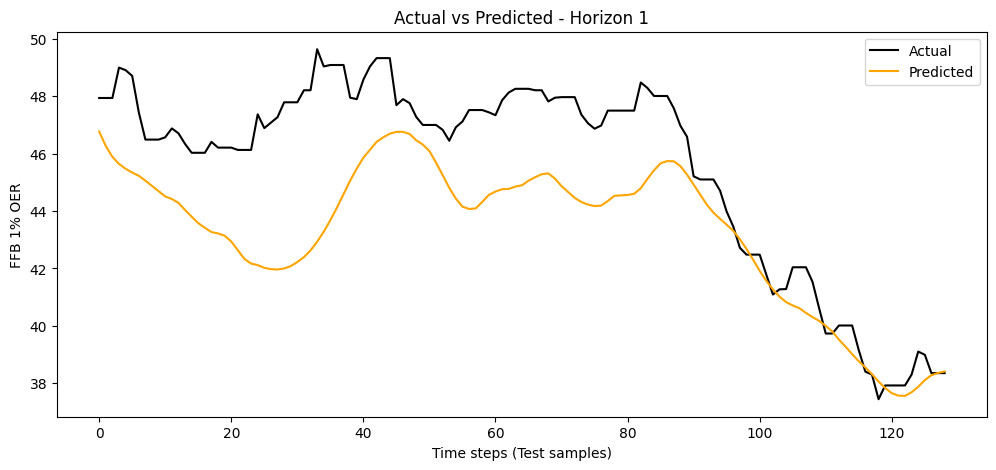

In [9]:
# Pick a horizon to visualize
h = 0  # Horizon 1 (next-day prediction)
plt.figure(figsize=(12,5))
plt.plot(y_test_lstm_inv[:, h], label='Actual', color='black')
plt.plot(y_pred_lstm_inv[:, h], label='Predicted', color='orange')
plt.title(f"Actual vs Predicted - Horizon {h+1}")
plt.xlabel("Time steps (Test samples)")
plt.ylabel("FFB 1% OER")
plt.legend()
plt.show()


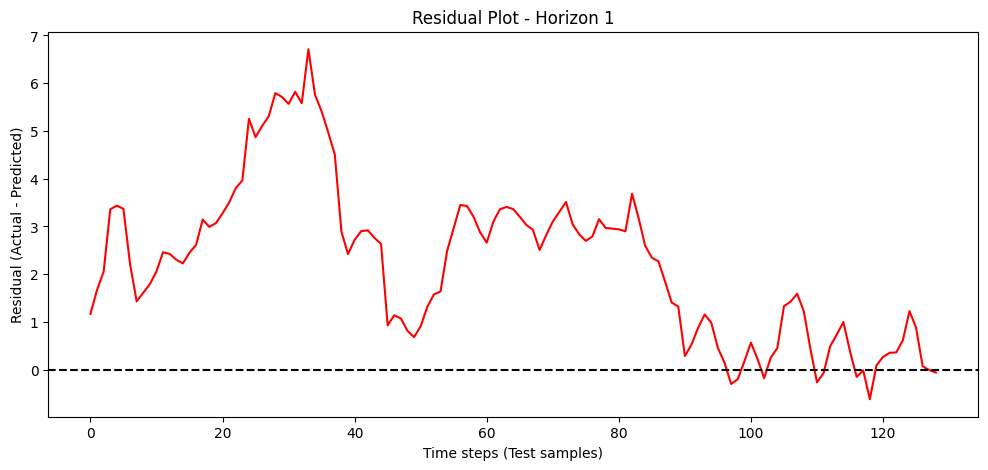

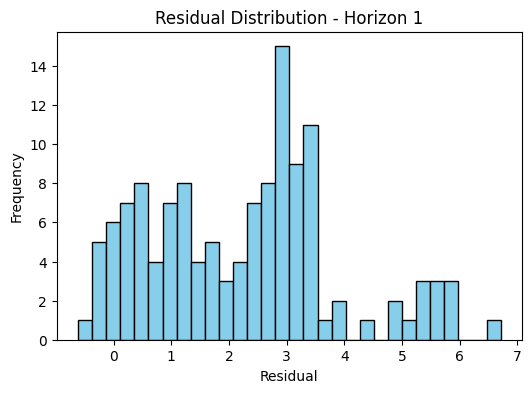

In [10]:
h = 0  # Horizon 1
residuals = y_test_lstm_inv[:, h] - y_pred_lstm_inv[:, h]

plt.figure(figsize=(12,5))
plt.plot(residuals, color='red')
plt.title(f"Residual Plot - Horizon {h+1}")
plt.xlabel("Time steps (Test samples)")
plt.ylabel("Residual (Actual - Predicted)")
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Optionally, histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='k')
plt.title(f"Residual Distribution - Horizon {h+1}")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


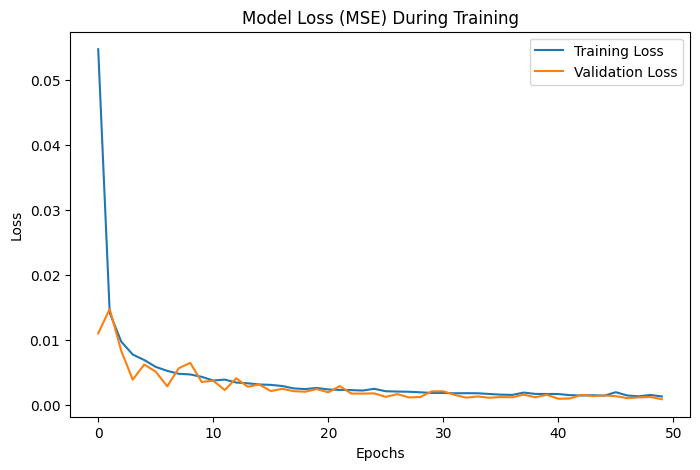

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss (MSE) During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


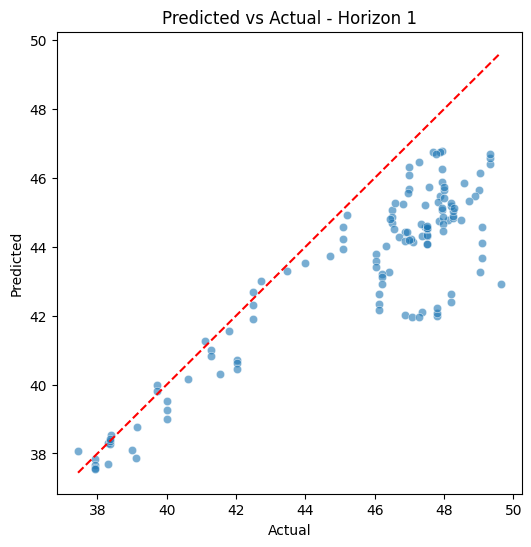

In [12]:
import seaborn as sns

h = 0
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_lstm_inv[:, h], y=y_pred_lstm_inv[:, h], alpha=0.6)
plt.plot([y_test_lstm_inv[:, h].min(), y_test_lstm_inv[:, h].max()],
         [y_test_lstm_inv[:, h].min(), y_test_lstm_inv[:, h].max()],
         color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual - Horizon {h+1}")
plt.show()


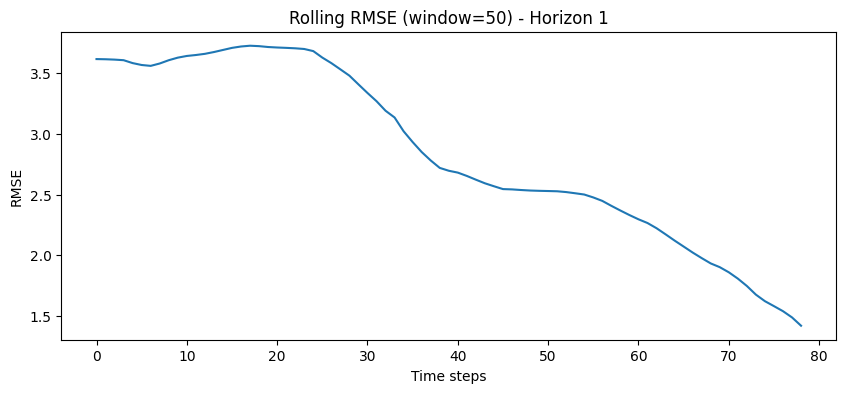

In [13]:
window = 50
rolling_rmse = [np.sqrt(np.mean((y_test_lstm_inv[i:i+window,0] - y_pred_lstm_inv[i:i+window,0])**2))
                 for i in range(len(y_test_lstm_inv)-window)]

plt.figure(figsize=(10,4))
plt.plot(rolling_rmse)
plt.title(f"Rolling RMSE (window={window}) - Horizon 1")
plt.xlabel("Time steps")
plt.ylabel("RMSE")
plt.show()


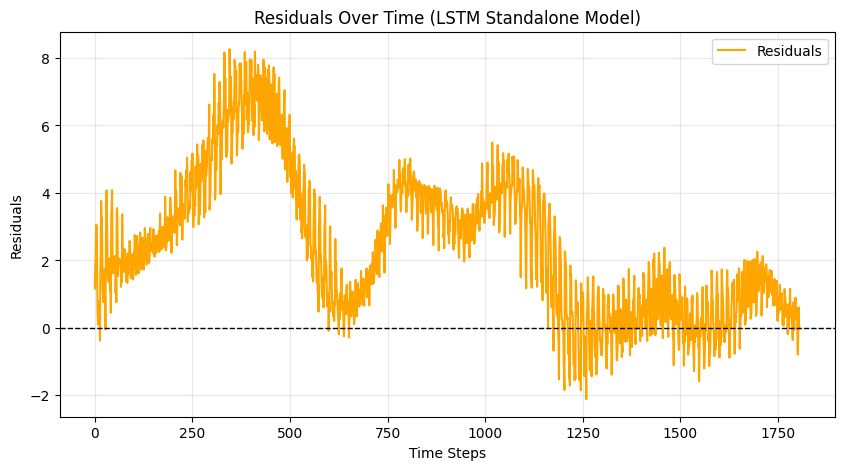

In [19]:
residuals = y_test_lstm_inv.flatten() - y_pred_lstm_inv.flatten()
plt.figure(figsize=(10,5))
plt.plot(residuals, color='orange', label="Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals Over Time (LSTM Standalone Model)")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

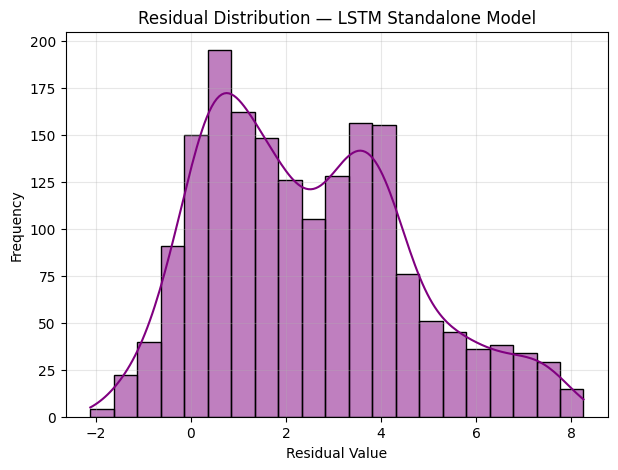

In [20]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution — LSTM Standalone Model")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()